#### A Jupyter Notebook for training a classification deep network used for classifying handwritten digits, i.e., MNIST dataset. After the training of the network, we will embed a watermark within some network weights and use it in inference mode

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import random

import torch
import torch.nn as nn

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

seed = 101

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms = True
torch.backends.cudnn.benchmark = False

#### Utility methods

In [2]:
def train(net, criterion, optimizer, n_epochs, train_loader, path_model='net.pt'):
    losses = []

    for epoch in range(n_epochs):
        net.train()

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            x, y = data
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred = net(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        losses.append(running_loss / len(train_loader))
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

    torch.save(net.state_dict(), path_model)
    
    plt.plot(range(0, len(losses)), losses)
    plt.title('Training losses')
    plt.show()
    
def test(net, test_loader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            x, y = data
            x, y = x.to(device), y.to(device)
            y_preds = net(x)
            _, predicted = torch.max(y_preds.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            
    return correct, total

In [3]:
def float_to_bin(x):
    # Convert float to binary representation
    return ''.join(f'{byte:08b}' for byte in np.float32(x).tobytes())

def bin_to_float(b):
    # Convert binary representation back to float
    int_bits = int(b, 2)
    return np.frombuffer(int_bits.to_bytes(4, byteorder='big'), dtype=np.float32)[0]

def add_watermark_lsb(net, watermark):
    watermark_bits = ''.join(f'{ord(c):08b}' for c in watermark) # Convert watermark to binary
    watermark_index = 0

    with torch.no_grad():
        for name, param in net.named_parameters():
            if name == 'fc2.weight':
                param_data = param.cpu().numpy()
                for i in np.ndindex(param_data.shape):
                    if watermark_index < len(watermark_bits):
                        original_bin = float_to_bin(param_data[i])
                        new_bin = original_bin[:-1] + watermark_bits[watermark_index]
                        param_data[i] = bin_to_float(new_bin)
                        watermark_index += 1
                param.copy_(torch.tensor(param_data, device=param.device))

                
def extract_watermark(net, watermark_length):
    extracted_bits = ''
    
    with torch.no_grad():
        for name, param in net.named_parameters():
            if name == 'fc2.weight':
                param_data = param.cpu().numpy()
                for i in np.ndindex(param_data.shape):
                    original_bin = float_to_bin(param_data[i])
                    extracted_bits += original_bin[-1]
    watermark_chars = [chr(int(extracted_bits[i:i+8], 2)) for i in range(0, len(extracted_bits), 8)]
    return ''.join(watermark_chars[:watermark_length])

#### Define the neural network

In [4]:
class Net(nn.Module):
    def __init__(self, n_channels=1, h_size=28, w_size=28, last_size=64, hidden_dim=8, n_classes=10):
        super(Net, self).__init__()
        self.n_channels = n_channels
        self.h_size = h_size
        self.w_size = w_size
        self.last_size = last_size
        self.n_classes = n_classes
        self.hidden_dim = hidden_dim
        
        self.embedder = nn.Sequential(
            nn.Conv2d(self.n_channels, self.last_size//2, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(self.last_size//2, self.last_size, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(self.last_size, self.last_size, kernel_size=3, stride=2),
            nn.ReLU()
        )
        
        
        out = self.embedder(torch.rand(1, self.n_channels, self.h_size, self.w_size))
        self.size = out.shape[2]

        self.fc1 = nn.Linear(self.last_size * self.size * self.size, self.last_size)
        self.fc2 = nn.Linear(self.last_size, self.hidden_dim)
        self.out = nn.Linear(self.hidden_dim, self.n_classes)
        
        self.relu = nn.ReLU()
        
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        x1 = self.embedder(x)
        x1 = x1.view(x1.shape[0], -1)
        
        x2 = self.fc1(x1)
        x2 = self.fc2(self.relu(x2))
        y = self.out(self.relu(x2))
        
        return y

#### Load the data

In [5]:
batch_size = 64
n_epochs = 20

path_model='net.pt'

In [6]:
transform = transforms.Compose([transforms.ToTensor()])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform) 
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform) 

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size)

#### Train the network

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

Epoch 1, Loss: 0.711593222182824
Epoch 2, Loss: 0.21592943611215237
Epoch 3, Loss: 0.12996958521431062
Epoch 4, Loss: 0.09854032191386355
Epoch 5, Loss: 0.07737914070949706
Epoch 6, Loss: 0.06300882291746761
Epoch 7, Loss: 0.0550968981990124
Epoch 8, Loss: 0.044884287308827577
Epoch 9, Loss: 0.03962349816855204
Epoch 10, Loss: 0.033374945941620195
Epoch 11, Loss: 0.029981619993336192
Epoch 12, Loss: 0.024924228950857254
Epoch 13, Loss: 0.023285554173950868
Epoch 14, Loss: 0.020647897175811072
Epoch 15, Loss: 0.018344306821322955
Epoch 16, Loss: 0.01601591983727286
Epoch 17, Loss: 0.01396803283611833
Epoch 18, Loss: 0.01342127939048734
Epoch 19, Loss: 0.013960768050938743
Epoch 20, Loss: 0.011433957718600335


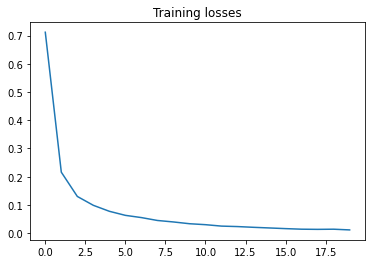

In [8]:
train(net, criterion, optimizer, n_epochs, train_loader, path_model)

#### Load the network and test it 

In [9]:
net.load_state_dict(torch.load(path_model))

<All keys matched successfully>

In [10]:
correct, total = test(net, test_loader)
print(f'Accuracy: {100 * correct / total}%')

Accuracy: 98.58%


#### Embed the watermark

In [11]:
# Now, we want to add a watermark into the fc2 weights
with torch.no_grad():
    for name, param in net.named_parameters():
        if name == 'fc2.weight':
            param_data = param.cpu().numpy()
            print(param_data)

[[ 3.52380052e-02  5.62173128e-01 -1.26857802e-01 -1.08864554e-03
  -7.86279887e-02  9.90515500e-02  1.12150028e-01  2.58520335e-01
  -2.26100925e-02 -1.53759057e-02 -1.05209224e-01  2.85302326e-02
   2.04063114e-02 -1.34602830e-01  2.16201901e-01 -1.56125368e-03
  -2.44291611e-02  4.46301669e-01 -2.84363050e-02  2.77920157e-01
  -3.05880439e-02  1.15929388e-01 -1.89442746e-02  1.00352295e-01
   1.45177217e-02  1.02079324e-01  4.87670563e-02  2.03172565e-01
  -1.09964848e-01  2.30804667e-01  1.12779163e-01 -3.51786196e-01
   2.91943979e-02  1.37668490e-01 -9.48298257e-03  4.48994637e-02
   1.64225727e-01  1.56570017e-01  4.97223698e-02 -1.36244521e-01
   3.86076123e-01  5.40191606e-02 -1.00916103e-02 -1.31050227e-02
   1.42773181e-01  3.65269999e-03 -2.86158137e-02  4.87360284e-02
  -2.37015169e-02  1.14381999e-01 -2.41468489e-01 -6.32218793e-02
   1.30570263e-01  1.62954698e-03  8.21532086e-02  7.68718868e-03
  -5.01250289e-03  8.46664142e-03 -1.45577103e-01 -1.19108362e-02
   1.95129

In [12]:
watermark = "AI4SS"
add_watermark_lsb(net, watermark)

In [13]:
# Check
with torch.no_grad():
    for name, param in net.named_parameters():
        if name == 'fc2.weight':
            param_data = param.cpu().numpy()
            print(param_data)

[[ 8.80950131e-03  5.62173128e-01 -1.26857802e-01 -1.08864554e-03
  -1.96569972e-02  2.47628875e-02  2.80375071e-02  1.03408134e+00
  -2.26100925e-02 -6.15036227e-02 -2.63023060e-02  2.85302326e-02
   8.16252455e-02 -1.34602830e-01  2.16201901e-01 -6.24501472e-03
  -2.44291611e-02  4.46301669e-01 -1.13745220e-01  1.11168063e+00
  -3.05880439e-02  1.15929388e-01 -1.89442746e-02  2.50880737e-02
   1.45177217e-02  1.02079324e-01  1.21917641e-02  8.12690258e-01
  -2.74912119e-02  2.30804667e-01  1.12779163e-01 -1.40714478e+00
   2.91943979e-02  5.50673962e-01 -9.48298257e-03  4.48994637e-02
   1.64225727e-01  1.56570017e-01  4.97223698e-02 -5.44978082e-01
   3.86076123e-01  5.40191606e-02 -1.00916103e-02 -1.31050227e-02
   1.42773181e-01  3.65269999e-03 -2.86158137e-02  4.87360284e-02
  -2.37015169e-02  1.14381999e-01 -2.41468489e-01 -6.32218793e-02
   1.30570263e-01  1.62954698e-03  8.21532086e-02  7.68718868e-03
  -5.01250289e-03  8.46664142e-03 -1.45577103e-01 -1.19108362e-02
   1.95129

In [14]:
correct, total = test(net, test_loader)
print(f'Accuracy: {100 * correct / total}%')

Accuracy: 94.68%


In [15]:
extracted_watermark = extract_watermark(net, len(watermark))
print(f'Extracted watermark: {extracted_watermark}')

Extracted watermark: AI4SS
